In [1]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import cv2
import easyocr
import kmeans1d

class tabParser():
    """   """
    def __init__(self, langs=['ru', 'en']) -> None:
        self.reader = easyocr.Reader(langs, gpu=True,) 


    def parse(self, img, path):
        # Binarization
        _, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
        img_bin = 255 - img_bin

        vertical_lines = self.get_verticals(img_bin)
        horizontal_lines = self.get_horizontals(img_bin)

        # Lines combination
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//500, np.array(img).shape[1]//500))

        vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
        _, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        vertical_horizontal_lines = cv2.dilate(vertical_horizontal_lines, kernel, iterations=1)
        
        boxes = self.get_boxes(vertical_horizontal_lines)

        col_count = sum(plt.hist(boxes[:, 0])[0] != 0)
        row_count = int(len(boxes)/(col_count))

        boxes_sorted = self.box_sort(boxes, col_count)

        final_df = self.detect_records(img_bin, boxes_sorted, row_count, col_count)

        final_df.to_excel(path)
        print(f'Saving to: {path}')

        return final_df


    def get_verticals(self, img):
        # Vertical lines extraction
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img).shape[1]//100))
        eroded_image = cv2.erode(img, vertical_kernel, iterations=3)
        vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=3)

        return vertical_lines


    def get_horizontals(self, img):
        # Horizontal lines extraction
        hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//100, 1))
        horizontal_lines = cv2.erode(img, hor_kernel, iterations=5)
        horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=5)

        return horizontal_lines


    def get_boxes(self, lines):
        # Get cells coordinates and size

        contours, hierarchy = cv2.findContours(lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        boundingBoxes = [cv2.minAreaRect(contour) for contour in contours]
        boxes = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            if (w < 1000 and h < 500):
                boxes.append([x, y, w, h])

        boxes = np.array(boxes)
        return boxes


    def box_sort(self, boxes, col_count):
        boxes_sorted = []

        row_class = np.c_[kmeans1d.cluster(boxes[:, 0], col_count)[0]]
        boxes_labeled = np.hstack((boxes, row_class))

        for i in range(col_count):
            column = boxes_labeled[boxes_labeled[:, -1] == i][:, :-1]
            col_sorted = sorted(column, key=lambda x: x[1])

            boxes_sorted.append(list(map(list, col_sorted)))

        boxes_sorted = [item for sublist in boxes_sorted for item in sublist]

        return boxes_sorted


    def detect_records(self, img, boxes, row_count, col_count):
        "Detection of cell containings"
        next_col = 0
        res_array = np.zeros((row_count, col_count))
        col_num = 0
        col_names = []

        for box in boxes:
            if next_col == row_count:
                next_col = 0
                col_num += 1

            y1, y2 = box[0], (box[0] + box[2])
            x1, x2 = box[1], (box[1] + box[3])

            img_roi = img[x1:x2, y1:y2]
            img_roi_blured = cv2.GaussianBlur(img_roi, (3,3), 3)
            _, img_roi_thr = cv2.threshold(img_roi_blured, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

            try:
                cell = self.reader.readtext(img_roi_thr)[0][1]
            except IndexError:
                print('Err')

            if next_col == 0:
                col_names.append(cell)
            else:
                try:
                    res_array[next_col, col_num] = cell
                except ValueError:
                    print('Err')

            next_col += 1

        res_df = pd.DataFrame(res_array[1:]).set_axis(col_names, axis=1, inplace=False)

        return res_df

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Err
Err
Err
Err
Err
Err
Err
Err
Err
Saving to: D:\Labs\DiplomaMag\Data\Sec_F.xlsx


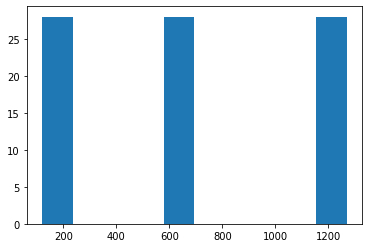

In [2]:
files_path = 'D:\\Labs\\DiplomaMag\\Data\\Photo'
save_to_path = 'D:\\Labs\\DiplomaMag\\Data'

onlyfiles = [f for f in listdir(files_path) if 'Sec_' in f]
parser = tabParser()

for file in onlyfiles:

    img = cv2.imread(join(files_path, file), 0)
    df = parser.parse(img, join(save_to_path, file.replace('.jpg', '.xlsx')))
    # print(join(files_path, file))